In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import time 
import gc 
import os


import matplotlib.pyplot as plt
import matplotlib.colors as colors

# xsuite
import xtrack as xt
import xfields as xf
import xobjects as xo

# BBStudies
import BBStudies.Physics.Constants as cst
import BBStudies.Tracking.Buffers as xBuff
import BBStudies.Tracking.Utils as xutils
import BBStudies.Plotting.BBPlots as bbplt

# Matplotlib config
#============================
FIGPATH  = './'
FIG_W = 6
FIG_H = 6


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "xtick.labelsize":14,
    "ytick.labelsize":14,
    "axes.labelsize":16,
    "axes.titlesize":16,
    "legend.fontsize":14,
    "legend.title_fontsize":16
})
plt.rc('text.latex', preamble=r'\usepackage{physics}')
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"
#============================




# Default locations
# ----------------------------
beam_list = ['b1', 'b2']
loc_list  = ['4l1','4r1','4l5','4r5']
ip_list   = ['ip1', 'ip5']
tank_list = ['a', 'b', 'c']
# ----------------------------


# ==================================================================================================
# --- Main script
# ==================================================================================================
def prepare_line(collider_file,seq='lhcb1',ip_name='ip1'):
    # Parameters
    #-------------------------------------
    disable_ho  = True

    if seq == 'lhcb1':
        beam_name   = 'b1'
        s_marker    = f'e.ds.l{ip_name[-1]}.b1'
        e_marker    = f's.ds.r{ip_name[-1]}.b1'
    else:
        beam_name   = 'b2'
        s_marker    = f's.ds.r{ip_name[-1]}.b2'
        e_marker    = f'e.ds.l{ip_name[-1]}.b2'
    #-------------------------------------


    # Loading collider
    #-------------------------------------
    collider    = xt.Multiline.from_json(collider_file)
    line0       = collider[seq]

    # Adjusting beam-beam
    #-------------------------------------
    _direction  = 'clockwise' if seq == 'lhcb1' else 'anticlockwise'
    bblr_names  = collider._bb_config['dataframes'][_direction].groupby('ip_name').get_group(ip_name).groupby('label').get_group('bb_lr').index.to_list()
    bbho_names  = collider._bb_config['dataframes'][_direction].groupby('ip_name').get_group(ip_name).groupby('label').get_group('bb_ho').index.to_list()
    if disable_ho:
        for nn in bbho_names:
            line0.element_refs[nn].scale_strength = 0

    # Making sure all LR are enabled
    for nn in bblr_names:
        assert line0.element_refs[nn].scale_strength._value == 1, f'LR element {nn} is not enabled'

    # Adjusting wires
    #-------------------------------------
    # Power master knobs
    for loc in loc_list:
        collider.vars[f'i_wire.{loc}.{beam_name}']  = 0
        collider.vars[f'dn_wire.{loc}.{beam_name}'] = 50


    # Extracting nemitt
    line0.metadata['nemitt_x'] = collider.metadata['config_collider']['config_beambeam']['nemitt_x']
    line0.metadata['nemitt_y'] = collider.metadata['config_collider']['config_beambeam']['nemitt_y']

    return line0,beam_name,s_marker,e_marker,bbho_names,bblr_names






collider_file = 'CR_HL_data/colliders/collider_pacman_250.json'
seq           = 'lhcb1'
ip_name       = 'ip1'


# Prepare line
#=======================================================================
context = xo.ContextCpu(omp_num_threads='auto')
line0,beam_name,s_marker,e_marker,bbho_names,bblr_names = prepare_line(collider_file,seq,ip_name)


twiss0      = line0.twiss4d()
twiss_init  = twiss0.get_twiss_init(at_element=s_marker)
line        = line0.select(s_marker,e_marker)
bbcw_names  = [nn for nn in line.element_names if 'bbcw' in nn]


_Iw = 0
_dn = 10

# Adjusting wires in both lines
#-------------------------------------
# Power master knobs
for loc in loc_list:
    line0.vars[f'i_wire.{loc}.{beam_name}']  = _Iw
    line0.vars[f'dn_wire.{loc}.{beam_name}'] = _dn
    line.vars[f'i_wire.{loc}.{beam_name}']   = _Iw
    line.vars[f'dn_wire.{loc}.{beam_name}']  = _dn

twiss0      = line0.twiss4d()
twiss_init  = twiss0.get_twiss_init(at_element=s_marker)
twiss       = line.twiss4d(start=line.element_names[0],end=line.element_names[-1],init=twiss_init)
#=======================================================================




# Collimation emittance
#---------------------------
nemitt_x = 2.5e-6
nemitt_y = 2.5e-6
gemittx = ( nemitt_x / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
gemitty = ( nemitt_y / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
#---------------------------


Loading line from dict:   0%|          | 0/24308 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/24338 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23674 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23704 [00:00<?, ?it/s]

Done loading line from dict.           


In [8]:
collider    = xt.Multiline.from_json(collider_file)

Loading line from dict:   0%|          | 0/24308 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/24338 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23674 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23704 [00:00<?, ?it/s]

Done loading line from dict.           


In [9]:
collider.metadata

{'b1': {'4l1': {'id': {'0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    '11': 11,
    '12': 12,
    '13': 13,
    '14': 14,
    '15': 15,
    '16': 16,
    '17': 17,
    '18': 18,
    '19': 19,
    '20': 20,
    '21': 21,
    '22': 22,
    '23': 23,
    '24': 24,
    '25': 25,
    '26': 26,
    '27': 27,
    '28': 28,
    '29': 29},
   'state': {'0': 'OFF',
    '1': 'OFF',
    '2': 'OFF',
    '3': 'OFF',
    '4': 'OFF',
    '5': 'OFF',
    '6': 'OFF',
    '7': 'OFF',
    '8': 'OFF',
    '9': 'OFF',
    '10': 'OFF',
    '11': 'OFF',
    '12': 'OFF',
    '13': 'OFF',
    '14': 'OFF',
    '15': 'OFF',
    '16': 'OFF',
    '17': 'OFF',
    '18': 'OFF',
    '19': 'OFF',
    '20': 'OFF',
    '21': 'OFF',
    '22': 'OFF',
    '23': 'OFF',
    '24': 'OFF',
    '25': 'OFF',
    '26': 'OFF',
    '27': 'OFF',
    '28': 'OFF',
    '29': 'OFF'},
   'tag': {'0': 'kq4.l1b1.bbcw',
    '1': 'kq4.l1b1.bbcw',
    '2': 'k

Text(0, 0.5, '$\\mu$ ')

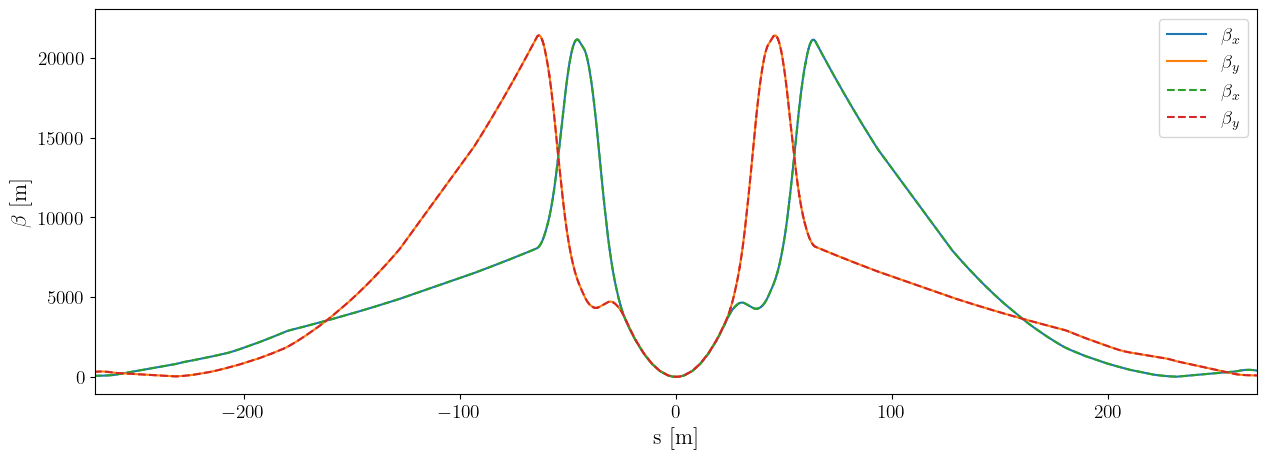

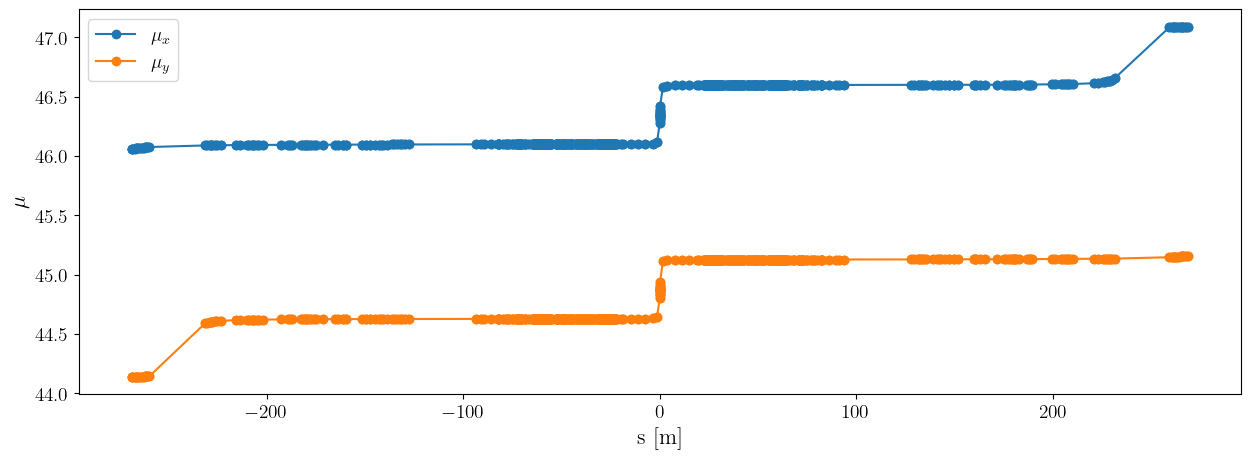

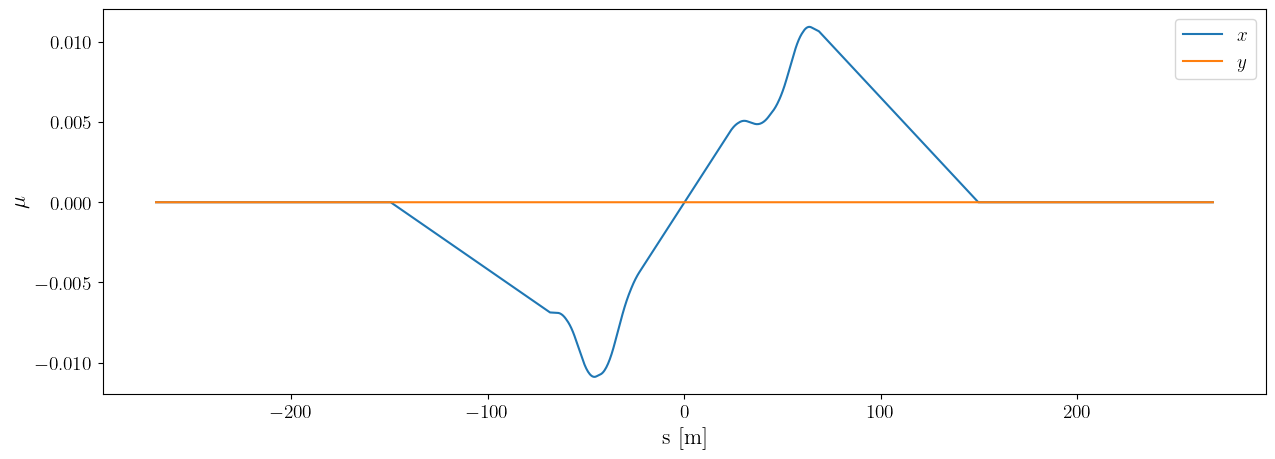

In [2]:

#===================================
# PLOTTING TWISS
plt.figure(figsize=(15,5))
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.betx,label=r'$\beta_x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.bety,label=r'$\beta_y$')
plt.plot(twiss0.s-twiss0.rows[ip_name].s,twiss0.betx,'--',label=r'$\beta_x$')
plt.plot(twiss0.s-twiss0.rows[ip_name].s,twiss0.bety,'--',label=r'$\beta_y$')
plt.xlim([np.min(twiss.s-twiss.rows[ip_name].s),np.max(twiss.s-twiss.rows[ip_name].s)])


plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\beta$ [m]')


plt.figure(figsize=(15,5))
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.mux,'-o',label=r'$\mu_x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.muy,'-o',label=r'$\mu_y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\mu$ ')

plt.figure(figsize=(15,5))
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.x,'-',label=r'$x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.y,'-',label=r'$y$')
# plt.plot(twiss0.s-twiss0.rows[ip_name].s,twiss0.x,'--',label=r'$x$')
# plt.plot(twiss0.s-twiss0.rows[ip_name].s,twiss0.y,'--',label=r'$y$')
# plt.xlim([np.min(twiss.s-twiss.rows[ip_name].s),np.max(twiss.s-twiss.rows[ip_name].s)])
plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\mu$ ')


In [3]:
import pandas as pd

def get_bblr_df(filename,ip_name='ip1',beam='b1'):
    import xtrack as xt
    import numpy as np
    collider = xt.Multiline.from_json(filename)
    IP1_LR  = collider._bb_config['dataframes']['clockwise'].groupby('ip_name').get_group('ip1').groupby('label').get_group('bb_lr').sort_values('identifier')
    IP5_LR  = collider._bb_config['dataframes']['clockwise'].groupby('ip_name').get_group('ip5').groupby('label').get_group('bb_lr').sort_values('identifier')
    line  = collider[f'lhc{beam}']

    # Deactivating BB
    #-------------------------------------
    line = collider['lhcb1']
    line.vars['beambeam_scale'] = 0.
    for ee_name in collider._bb_config['dataframes']['clockwise'].elementName:
        line.element_refs[ee_name].scale_strength = 0.

    # Twiss
    twiss = line.twiss4d() 


    # Collimation emittance
    #---------------------------
    nemitt_x = 2.5e-6
    nemitt_y = 2.5e-6
    gemittx = ( nemitt_x / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
    gemitty = ( nemitt_y / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
    #---------------------------

    twiss_keys  = ['name', 's', 'betx', 'bety','alfx','alfy','x','y','mux','muy']
    bblr_dict   = {}
    for ee_name in list(IP1_LR.elementName)+list(IP5_LR.elementName):
        ee = line[ee_name].to_dict()

        # Twiss info
        for key in twiss_keys:
            if key not in bblr_dict.keys():
                bblr_dict[key] = []
            
            bblr_dict[key].append(twiss.rows[ee_name][key][0])


        for key in ee.keys():
            if key not in bblr_dict.keys():
                bblr_dict[key] = []
            bblr_dict[key].append(ee[key])


    bblr_df = pd.DataFrame(bblr_dict)

    # Computing relevant quantities
    #--------
    ID_limit = 20
    bblr_df = bblr_df[bblr_df.name.str.contains(f'{ip_name[-1]}{beam}')]
    bblr_df.insert(0,'ID',bblr_df.name.apply(lambda name: -int(name.split('_')[-1]) if ('l1' in name or 'l5' in name) else int(name.split('_')[-1]) ))
    bblr_df = bblr_df[np.abs(bblr_df.ID)<=ID_limit]
    #--------
    bblr_df.insert(2,'dx_n'     ,(bblr_df.other_beam_shift_x - bblr_df.ref_shift_x)/np.sqrt(gemittx*bblr_df.betx))
    bblr_df.insert(3,'dy_n'     ,(bblr_df.other_beam_shift_y - bblr_df.ref_shift_y)/np.sqrt(gemitty*bblr_df.bety))
    bblr_df.insert(4,'sigx_w'   , np.sqrt(gemittx*bblr_df.betx))
    bblr_df.insert(5,'sigy_w'   , np.sqrt(gemitty*bblr_df.bety))
    bblr_df.insert(6,'sigx_s'   , np.sqrt(bblr_df.other_beam_Sigma_11))
    bblr_df.insert(7,'sigy_s'   , np.sqrt(bblr_df.other_beam_Sigma_33))
    #--------

    return bblr_df


def get_bbcw_df(filename,ip_name='ip1',beam='b1'):
    import xtrack as xt
    import numpy as np
    collider = xt.Multiline.from_json(filename)
    line  = collider[f'lhc{beam}']


    # Deactivating BB
    #-------------------------------------
    line = collider['lhcb1']
    line.vars['beambeam_scale'] = 0.
    for ee_name in collider._bb_config['dataframes']['clockwise'].elementName:
        line.element_refs[ee_name].scale_strength = 0.

    # Twiss
    twiss = line.twiss4d() 


    # Default locations
    # ----------------------------
    beam_list = [beam]
    loc_list  = [f'4l{ip_name[-1]}',f'4r{ip_name[-1]}']
    # ip_list   = [ip_name]
    tank_list = ['a', 'b', 'c']
    
    bbcw_names = []
    for beam_name in beam_list:
        for loc in loc_list:
            for tank in tank_list:
                bbcw_names.append(f'bbcw.{tank}.{loc}.{beam_name}')
    # ----------------------------



    # Collimation emittance
    #---------------------------
    nemitt_x = 2.5e-6
    nemitt_y = 2.5e-6
    gemittx = ( nemitt_x / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
    gemitty = ( nemitt_y / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
    #---------------------------

    twiss_keys  = ['name', 's', 'betx', 'bety','alfx','alfy','x','y','mux','muy']
    bbcw_dict   = {}
    for ee_name in bbcw_names:
        ee = line[ee_name].to_dict()

        # Twiss info
        for key in twiss_keys:
            if key not in bbcw_dict.keys():
                bbcw_dict[key] = []
            
            bbcw_dict[key].append(twiss.rows[ee_name][key][0])


        for key in ee.keys():
            if key not in bbcw_dict.keys():
                bbcw_dict[key] = []
            bbcw_dict[key].append(ee[key])


    bbcw_df = pd.DataFrame(bbcw_dict)

    # Computing relevant quantities
    bbcw_df.insert(2,'rho'   , bbcw_df.bety/bbcw_df.betx)
    #--------

    return bbcw_df


bblr_df = get_bblr_df(collider_file,ip_name=ip_name,beam=seq[-2:])
bbcw_df = get_bbcw_df(collider_file,ip_name=ip_name,beam=seq[-2:])
bb_I = bblr_df.other_beam_num_particles.unique()[0]

Loading line from dict:   0%|          | 0/24308 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/24338 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23674 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23704 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/24308 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/24338 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23674 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23704 [00:00<?, ?it/s]

Done loading line from dict.           


Text(0, 0.5, '$\\beta_y/\\beta_x$')

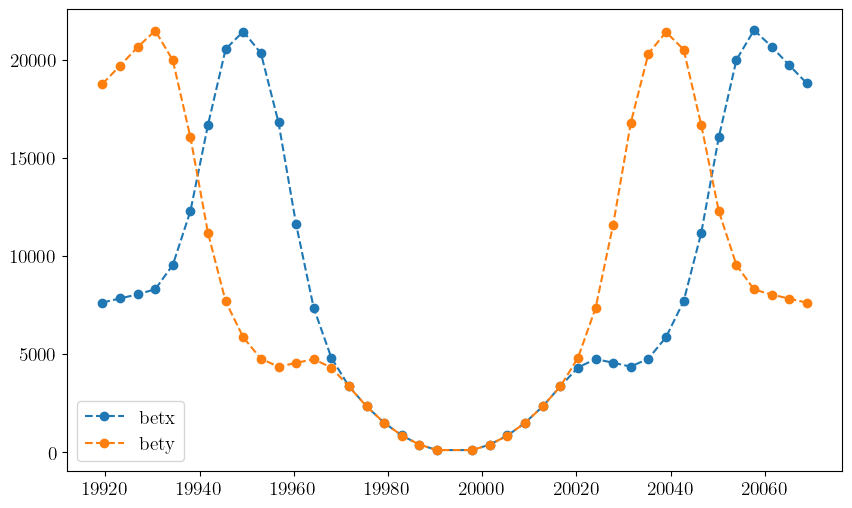

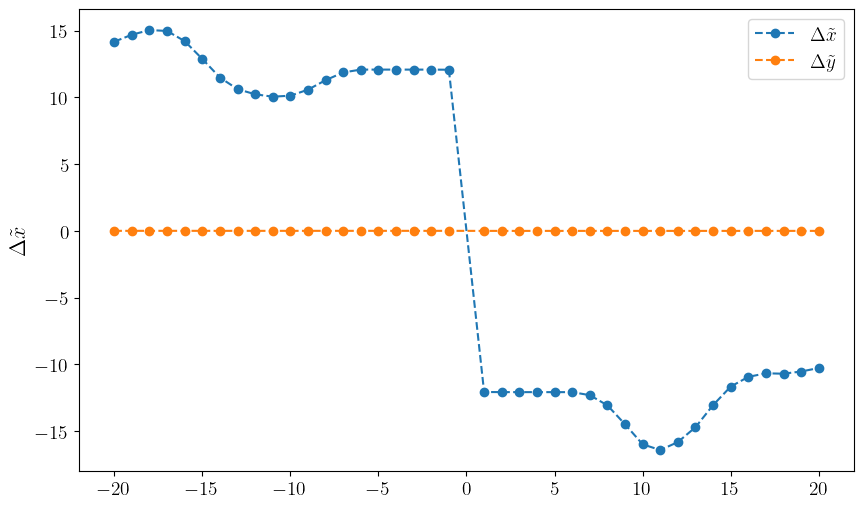

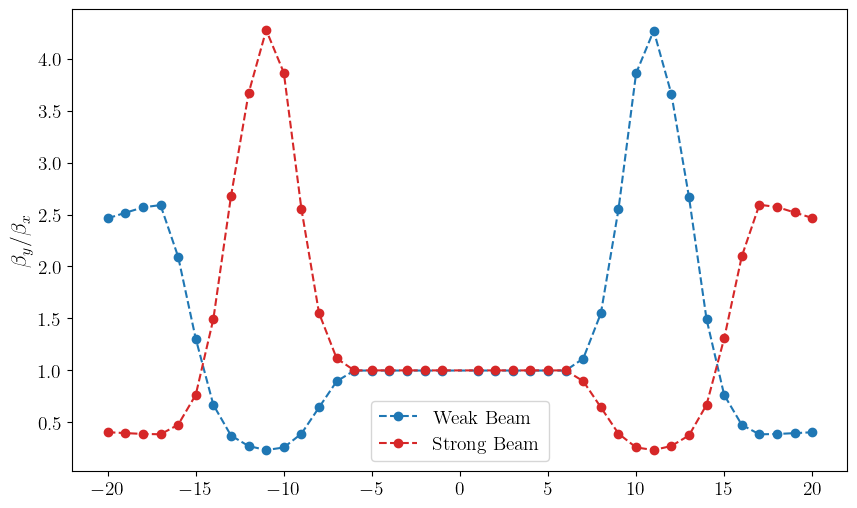

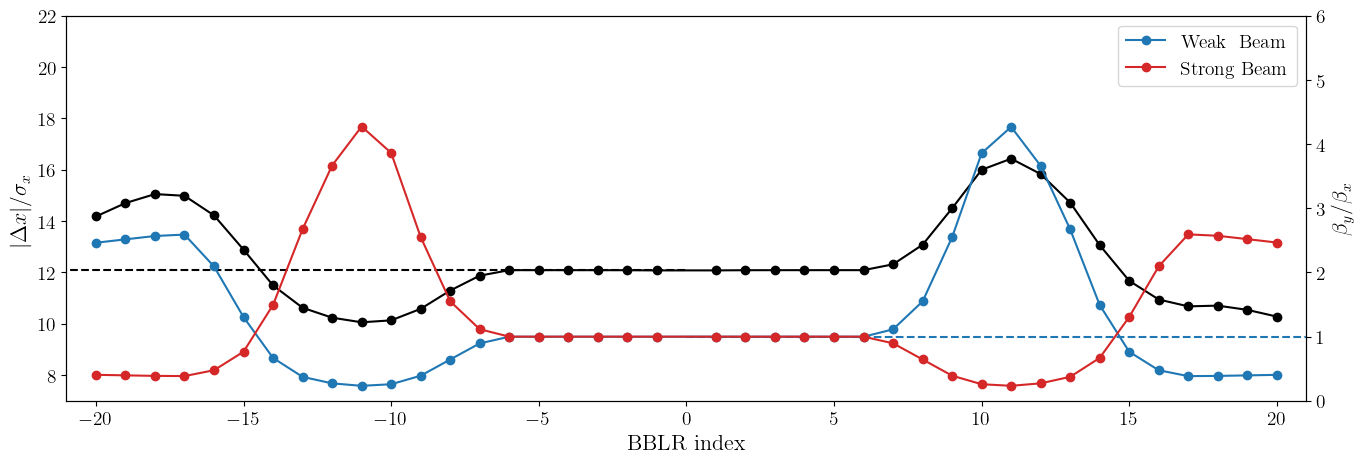

In [4]:


# PLOT TWISS
#==============================
plt.figure(figsize=(10,6))
plt.plot(bblr_df.s,bblr_df.betx,'--o',label='betx')
plt.plot(bblr_df.s,bblr_df.bety,'--o',label='bety')
plt.legend()
#==============================



plt.figure(figsize=(10,6))
plt.plot(bblr_df.ID,bblr_df.dx_n,'--o',label=rf'$\Delta \tilde x$')
plt.plot(bblr_df.ID,bblr_df.dy_n,'--o',label=rf'$\Delta \tilde y$')
plt.legend()
plt.ylabel(rf'$\Delta \tilde x$')


plt.figure(figsize=(10,6))
plt.plot(bblr_df.ID,bblr_df.sigy_w**2/bblr_df.sigx_w**2,'--o',label='Weak Beam')
plt.plot(bblr_df.ID,bblr_df.sigy_s**2/bblr_df.sigx_s**2,'--o',color='C3',label='Strong Beam')
plt.legend()
plt.ylabel(rf'$\beta_y/\beta_x$')


plt.figure(figsize=(16,5))
plt.hlines(bblr_df.set_index('ID').loc[-1].dx_n,-22,0,ls='--',color='k')
plt.plot(bblr_df.ID,np.abs(bblr_df.dx_n),'-o',color='k')

plt.ylim([7,22])
plt.xlim([-21,21])
plt.ylabel(rf'$|\Delta x|/\sigma_x$')
plt.xlabel(rf'BBLR index')
plt.gca().twinx()
plt.hlines(1,0,22,ls='--',color='C0')
plt.plot(bblr_df.ID,bblr_df.sigy_w**2/bblr_df.sigx_w**2,'-o',label='Weak \  Beam')
plt.plot(bblr_df.ID,bblr_df.sigy_s**2/bblr_df.sigx_s**2,'-o',color='C3',label='Strong Beam')
plt.legend()
plt.ylim([0,6])
plt.ylabel(rf'$\beta_y/\beta_x$')

In [11]:
bbcw_names 


['bbcw.c.4l1.b1',
 'bbcw.b.4l1.b1',
 'bbcw.a.4l1.b1',
 'bbcw.a.4r1.b1',
 'bbcw.b.4r1.b1',
 'bbcw.c.4r1.b1']

In [22]:
gemittx

np.float64(3.350971773531053e-10)

In [25]:
for wire in bbcw_names:
    print(line[wire].current,(line[wire].xma-twiss.rows[wire].x[0])/np.sqrt(gemittx*twiss.rows[wire].betx[0]))

150.0 10.1002503477053
150.0 10.09998973362643
150.0 10.09954251510761
150.0 -10.101373849949844
150.0 -10.102301717790013
150.0 -10.102919188123533


In [28]:
line[wire].to_dict()

{'__class__': 'Wire',
 'post_subtract_px': np.float64(-1.9277663640560007e-07),
 'L_int': np.float64(10.0),
 'xma': np.float64(-0.0066648368609254815),
 'yma': np.float64(-4.4044216682263743e-10),
 'post_subtract_py': np.float64(-1.2739540550355199e-14),
 'L_phy': np.float64(1.0),
 'current': np.float64(150.0)}

In [19]:
    # Collimation emittance
    #---------------------------
    nemitt_x = 2.5e-6
    nemitt_y = 2.5e-6
    gemittx = ( nemitt_x / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
    gemitty = ( nemitt_y / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
    #---------------------------